In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate, train_test_split
from imblearn.over_sampling import SMOTE #synthetic minority oversampling technique (smote)

In [2]:
data = pd.read_csv("data.csv")

## Data Prep:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 28 columns):
Unnamed: 0               30697 non-null int64
match_event_id           29134 non-null float64
location_x               29236 non-null float64
location_y               29157 non-null float64
remaining_min            29135 non-null float64
power_of_shot            29211 non-null float64
knockout_match           29180 non-null float64
game_season              24835 non-null object
remaining_sec            29103 non-null float64
distance_of_shot         29130 non-null float64
is_goal                  24429 non-null float64
area_of_shot             29195 non-null object
shot_basics              29122 non-null object
range_of_shot            29133 non-null object
team_name                29162 non-null object
date_of_game             29147 non-null object
home/away                29200 non-null object
shot_id_number           29134 non-null float64
lat/lng                  29132 non-n

In [4]:
# Dropped unnecessary column
data=data.drop(['Unnamed: 0'], axis=1)

In [5]:
# It's evident from info that there are many missing values in all columns, except, match_id and team_id columns
# Checking count of null values in each columns
data.isnull().sum()

match_event_id            1563
location_x                1461
location_y                1540
remaining_min             1562
power_of_shot             1486
knockout_match            1517
game_season               5862
remaining_sec             1594
distance_of_shot          1567
is_goal                   6268
area_of_shot              1502
shot_basics               1575
range_of_shot             1564
team_name                 1535
date_of_game              1550
home/away                 1497
shot_id_number            1563
lat/lng                   1565
type_of_shot             15280
type_of_combined_shot    15417
match_id                     0
team_id                      0
remaining_min.1           1535
power_of_shot.1           1539
knockout_match.1          1493
remaining_sec.1           1539
distance_of_shot.1        1568
dtype: int64

In [6]:
data.head()[['type_of_shot', 'type_of_combined_shot']]


,type_of_shot,type_of_combined_shot
0,shot - 30,NaN
1,shot - 45,NaN
2,shot - 25,NaN
3,NaN,shot - 3
4,NaN,shot - 1


In [7]:
## columns 'game_season', 'type_of_shot' and 'type_of_combined_shot' have huge number of values which are missing. 
# Hence, these 3 columns need separate processing

#game_season missing values can be updated using data from 'date_of_game'

In [8]:
data.pivot_table(index='type_of_shot',  values=['type_of_combined_shot'], aggfunc=['count']).T

,type_of_shot,shot - 0,shot - 1,shot - 10,shot - 11,shot - 12,shot - 13,shot - 14,shot - 15,shot - 16,shot - 17,...,shot - 51,shot - 52,shot - 53,shot - 54,shot - 55,shot - 56,shot - 6,shot - 7,shot - 8,shot - 9
count,type_of_combined_shot,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
data.pivot_table(index='type_of_combined_shot',  values=['type_of_shot'], aggfunc=['count'])

,count
,type_of_shot
type_of_combined_shot,
shot - 0,0
shot - 1,0
shot - 2,0
shot - 3,0
shot - 4,0
shot - 5,0


In [10]:
data.pivot_table(index='game_season',  values=['date_of_game'], aggfunc=['count']).T

,game_season,1996-97,1997-98,1998-99,1999-00,2000-01,2001-02,2002-03,2003-04,2004-05,2005-06,2006-07,2007-08,2008-09,2009-10,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16
count,date_of_game,361,772,723,1204,1411,1557,1723,1275,1012,1810,1452,1639,1722,1579,1374,1255,1234,57,567,861


In [11]:
# Both columns need to be merged to get all data for 'type_of_shot'. 

data['type_of_shot'] = data['type_of_shot'].fillna(data['type_of_combined_shot'])
data['type_of_shot'].isna().sum()

0

In [12]:
# if the given game-date is beyond june, then its season is thisyear-nextyear eg.2019-20
# else its season is previousyear-thisyear eg. 2018-19

def fseason(year, month):
    
    if(month >=6):
        next_year = str(year+1)[2:]
        season= str(year)+'-'+ next_year
        
    else:
        next_year = str(year)[2:]
        season=str(year-1)+'-'+ next_year
    return season

In [13]:
# fetching season from the date_of_game, when its not null
data["date_of_game"]= pd.to_datetime(data["date_of_game"]) 
date_of_game = data[data['date_of_game'].notna()]['date_of_game']

data["season_of_game"] = date_of_game.apply(lambda x: fseason(x.year, x.month))

# replacing season's null values with those of 'game_season' 
data['season_of_game'] = data['season_of_game'].fillna(data['game_season'])
data['season_of_game'].isna().sum()

303

In [14]:
#since, 'type_of_combined_shot', 'game_season' & 'date_of_game' contains duplicate & partial data, it need to be dropped now
# since, 'team_id' and 'team_name' have same value for all samples, hence, dropping them from the independant variables
data = data.drop(['type_of_combined_shot', 'game_season', 'date_of_game', 'team_name', 'team_id'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 23 columns):
match_event_id        29134 non-null float64
location_x            29236 non-null float64
location_y            29157 non-null float64
remaining_min         29135 non-null float64
power_of_shot         29211 non-null float64
knockout_match        29180 non-null float64
remaining_sec         29103 non-null float64
distance_of_shot      29130 non-null float64
is_goal               24429 non-null float64
area_of_shot          29195 non-null object
shot_basics           29122 non-null object
range_of_shot         29133 non-null object
home/away             29200 non-null object
shot_id_number        29134 non-null float64
lat/lng               29132 non-null object
type_of_shot          30697 non-null object
match_id              30697 non-null int64
remaining_min.1       29162 non-null float64
power_of_shot.1       29158 non-null float64
knockout_match.1      29204 non-null float64

In [15]:
# Replaced all non-categorical column missing values with median of the column. 
# Since, 'is_goal' is the dependant variable, not handling it for missing values.

non_cat_data = data.select_dtypes(exclude = ['object']).drop(['is_goal', 'shot_id_number'], axis=1).apply(lambda x: x.fillna(x.median()),axis=0)

# Replaced all categorical column missing values with the most frequent  of the column.
# Removed ['game_season','type_of_shot', 'type_of_combined_shot'] from the general category list, as due to high missing values, they need separate processing
cat_data = data.select_dtypes(include = ['object']).apply(lambda x: x.fillna(x.value_counts().idxmax()),axis=0)

# concating all type of data into a dataframe, for further processing
df = pd.concat([data[['is_goal', 'shot_id_number']],cat_data, non_cat_data ], axis=1)

# Also, since, 'shot_id_number' is a sequence number, it need to have sequential values
# Adding 'shot_id_number' column with values - 1 to n
df['shot_id_number'] = np.arange(1,len(df['shot_id_number'])+1)

In [16]:
# Setting shot_id_number is index, as the result is expected in the same format.
df = df.set_index('shot_id_number', drop=True)

In [17]:
# Confirming that there is no missing data except for is_goal
df.isna().sum()

is_goal               6268
area_of_shot             0
shot_basics              0
range_of_shot            0
home/away                0
lat/lng                  0
type_of_shot             0
season_of_game           0
match_event_id           0
location_x               0
location_y               0
remaining_min            0
power_of_shot            0
knockout_match           0
remaining_sec            0
distance_of_shot         0
match_id                 0
remaining_min.1          0
power_of_shot.1          0
knockout_match.1         0
remaining_sec.1          0
distance_of_shot.1       0
dtype: int64

In [18]:
# bringing data to same format
df['home/away'] = df['home/away'].replace(to_replace='@', value='vs.' ,regex=True)

In [19]:
df['remaining_seconds'] = df['remaining_min']*60 + df['remaining_sec']
df['remaining_seconds.1'] = df['remaining_min.1']*60 + df['remaining_sec.1']
df= df.drop(['remaining_sec', 'remaining_min'], axis=1) # as new feature 'remaining_seconds' created using both these

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_goal,24429.0,4.453314e-01,4.970125e-01,0.0,0.0,0.0,1.0,1.000000e+00
match_event_id,30697.0,2.498013e+02,1.463157e+02,2.0,118.0,254.0,361.0,6.590000e+02
location_x,30697.0,7.032446e+00,1.076185e+02,-250.0,-59.0,0.0,90.0,2.480000e+02
location_y,30697.0,9.026771e+01,8.553051e+01,-44.0,7.0,74.0,156.0,7.910000e+02
power_of_shot,30697.0,2.542626e+00,1.130414e+00,1.0,2.0,3.0,3.0,7.000000e+00
knockout_match,30697.0,1.387432e-01,3.456840e-01,0.0,0.0,0.0,0.0,1.000000e+00
distance_of_shot,30697.0,3.352806e+01,9.133751e+00,20.0,26.0,35.0,40.0,9.900000e+01
match_id,30697.0,2.476407e+07,7.755175e+06,20000012.0,20500077.0,20900354.0,29600474.0,4.990009e+07
remaining_min.1,30697.0,1.759432e+01,2.879515e+01,0.0,3.0,6.0,10.0,1.287616e+02
power_of_shot.1,30697.0,1.534265e+01,2.906197e+01,1.0,2.0,3.0,4.0,1.183600e+02


## Spliting of test & train data


In [21]:
eda_data = df;

is_goal = eda_data[eda_data['is_goal'] == 1]
not_goal = eda_data[eda_data['is_goal'] == 0]

is_goal.shape , not_goal.shape

# Observatoin: There is class imbalance.

((10879, 22), (13550, 22))

# EDA:

In [22]:
## area_of_shot, shot_basics, range_of_shot, type_of_shot, distance_of_shot

In [23]:
eda_data['area_of_shot'].value_counts()

Center(C)                14263
Right Side Center(RC)     4562
Right Side(R)             4370
Left Side Center(LC)      3848
Left Side(L)              3573
Mid Ground(MG)              81
Name: area_of_shot, dtype: int64

In [24]:
eda_data['shot_basics'].value_counts()

Mid Range          13530
Goal Area           6787
Penalty Spot        5321
Goal Line           4357
Right Corner         367
Left Corner          268
Mid Ground Line       67
Name: shot_basics, dtype: int64

In [25]:
eda_data['range_of_shot'].value_counts()

Less Than 8 ft.    10497
16-24 ft.           7892
8-16 ft.            6290
24+ ft.             5937
Back Court Shot       81
Name: range_of_shot, dtype: int64

In [26]:
eda_data['type_of_shot'].value_counts()

shot - 3     11850
shot - 4      3865
shot - 39     1445
shot - 36     1292
shot - 1       822
shot - 15      701
shot - 38      676
shot - 44      609
shot - 43      400
shot - 17      382
shot - 12      361
shot - 52      338
shot - 46      320
shot - 32      303
shot - 56      290
shot - 5       250
shot - 2       242
shot - 49      222
shot - 31      218
shot - 27      203
shot - 0       197
shot - 10      197
shot - 55      196
shot - 51      196
shot - 26      194
shot - 18      185
shot - 29      182
shot - 24      179
shot - 9       174
shot - 16      173
shot - 22      173
shot - 20      169
shot - 19      168
shot - 54      168
shot - 21      165
shot - 48      163
shot - 42      159
shot - 30      158
shot - 53      157
shot - 13      157
shot - 23      152
shot - 8       152
shot - 6       152
shot - 45      151
shot - 37      150
shot - 50      145
shot - 28      144
shot - 41      143
shot - 40      143
shot - 14      142
shot - 35      141
shot - 25      138
shot - 11   

In [27]:
eda_data['distance_of_shot'].value_counts()

20.0    5258
35.0    2670
45.0    1856
44.0    1433
37.0    1415
38.0    1341
36.0    1339
39.0    1299
46.0    1213
40.0    1144
34.0    1011
33.0     892
41.0     768
32.0     745
27.0     672
30.0     668
31.0     652
42.0     646
28.0     640
26.0     611
21.0     597
29.0     581
22.0     541
43.0     539
25.0     508
47.0     486
23.0     361
24.0     350
48.0     181
49.0      77
        ... 
63.0       5
72.0       4
78.0       4
64.0       4
69.0       4
76.0       4
82.0       3
79.0       3
75.0       3
70.0       3
74.0       3
71.0       3
94.0       3
67.0       3
68.0       3
73.0       2
81.0       2
66.0       2
65.0       2
88.0       2
90.0       2
87.0       2
84.0       2
97.0       1
89.0       1
80.0       1
77.0       1
85.0       1
99.0       1
91.0       1
Name: distance_of_shot, Length: 73, dtype: int64

In [28]:
is_goal['area_of_shot'].value_counts().idxmax() , is_goal['shot_basics'].value_counts().idxmax(), is_goal['range_of_shot'].value_counts().idxmax(), is_goal['type_of_shot'].value_counts().idxmax()

('Center(C)', 'Mid Range', 'Less Than 8 ft.', 'shot - 3')

In [29]:
#eda_data.groupby(['type_of_shot', 'range_of_shot'], axis=1).count()
eda_data.groupby(['type_of_shot','shot_basics','area_of_shot']).range_of_shot.value_counts(normalize=True)

type_of_shot  shot_basics      area_of_shot           range_of_shot  
shot - 0      Goal Area        Center(C)              Less Than 8 ft.    1.000000
              Goal Line        Center(C)              Less Than 8 ft.    0.829268
                                                      8-16 ft.           0.170732
                               Left Side(L)           8-16 ft.           1.000000
                               Right Side(R)          8-16 ft.           1.000000
              Left Corner      Center(C)              24+ ft.            1.000000
                               Left Side(L)           24+ ft.            1.000000
              Mid Ground Line  Mid Ground(MG)         Back Court Shot    1.000000
              Mid Range        Center(C)              Less Than 8 ft.    0.461538
                                                      16-24 ft.          0.384615
                                                      8-16 ft.           0.153846
                            

In [30]:
eda_data.groupby(['range_of_shot']).shot_basics.value_counts(normalize=True)

range_of_shot    shot_basics    
16-24 ft.        Mid Range          1.000000
24+ ft.          Penalty Spot       0.845545
                 Right Corner       0.058615
                 Mid Range          0.053394
                 Left Corner        0.042446
8-16 ft.         Mid Range          0.667409
                 Goal Line          0.332591
Back Court Shot  Mid Ground Line    0.802469
                 Penalty Spot       0.148148
                 Mid Range          0.049383
Less Than 8 ft.  Goal Area          0.646566
                 Goal Line          0.215776
                 Mid Range          0.106602
                 Penalty Spot       0.027532
                 Right Corner       0.001810
                 Left Corner        0.001524
                 Mid Ground Line    0.000191
Name: shot_basics, dtype: float64

In [31]:
pd.crosstab(index=eda_data['shot_basics'], columns=[eda_data['range_of_shot'], eda_data['area_of_shot']], normalize=True ).T*100

shot_basics                            Goal Area  Goal Line  Left Corner  \
range_of_shot   area_of_shot                                               
16-24 ft.       Center(C)               0.000000   0.000000     0.000000   
                Left Side Center(LC)    0.000000   0.000000     0.000000   
                Left Side(L)            0.000000   0.000000     0.000000   
                Right Side Center(RC)   0.000000   0.000000     0.000000   
                Right Side(R)           0.000000   0.000000     0.000000   
24+ ft.         Center(C)               0.000000   0.000000     0.032576   
                Left Side Center(LC)    0.000000   0.000000     0.000000   
                Left Side(L)            0.000000   0.000000     0.788351   
                Right Side Center(RC)   0.000000   0.000000     0.000000   
                Right Side(R)           0.000000   0.000000     0.000000   
8-16 ft.        Center(C)               0.000000   4.384793     0.000000   
                Left Side(L)            0.000000   1.068508     0.000000   
                Right Side(R)           0.000000   1.361697     0.000000   
Back Court Shot Center(C)               0.000000   0.000000     0.000000   
                Mid Ground(MG)          0.000000   0.000000     0.000000   
Less Than 8 ft. Center(C)              22.109652   7.271069     0.000000   
                Left Side Center(LC)    0.000000   0.000000     0.000000   
                Left Side(L)            0.000000   0.035834     0.052122   
                Mid Ground(MG)          0.000000   0.000000     0.000000   
                Right Side Center(RC)   0.000000   0.000000     0.000000   
                Right Side(R)           0.000000   0.071668     0.000000   

shot_basics                            Mid Ground Line  Mid Range  \
range_of_shot   area_of_shot                                        
16-24 ft.       Center(C)                     0.000000   4.759423   
                Left Side Center(LC)          0.000000   5.524970   
                Left Side(L)                  0.000000   3.684399   
                Right Side Center(RC)         0.000000   7.176597   
                Right Side(R)                 0.000000   4.563964   
24+ ft.         Center(C)                     0.000000   0.221520   
                Left Side Center(LC)          0.000000   0.348568   
                Left Side(L)                  0.000000   0.032576   
                Right Side Center(RC)         0.000000   0.368114   
                Right Side(R)                 0.000000   0.061895   
8-16 ft.        Center(C)                     0.000000   1.755872   
                Left Side(L)                  0.000000   5.502166   
                Right Side(R)                 0.000000   6.417565   
Back Court Shot Center(C)                     0.006515   0.000000   
                Mid Ground(MG)                0.205232   0.013031   
Less Than 8 ft. Center(C)                     0.000000   1.847086   
                Left Side Center(LC)          0.000000   0.286673   
                Left Side(L)                  0.000000   0.475617   
                Mid Ground(MG)                0.006515   0.000000   
                Right Side Center(RC)         0.000000   0.430009   
                Right Side(R)                 0.000000   0.605922   

shot_basics                            Penalty Spot  Right Corner  
range_of_shot   area_of_shot                                       
16-24 ft.       Center(C)                  0.000000      0.000000  
                Left Side Center(LC)       0.000000      0.000000  
                Left Side(L)               0.000000      0.000000  
                Right Side Center(RC)      0.000000      0.000000  
                Right Side(R)              0.000000      0.000000  
24+ ft.         Center(C)                  3.857054      0.042349  
                Left Side Center(LC)       6.007102      0.000000  
                Left Side(L)               0.000000

In [32]:
pd.crosstab(index=is_goal['shot_basics'], columns=[is_goal['range_of_shot'], is_goal['area_of_shot'] ], normalize=True)*100

range_of_shot   16-24 ft.                                    \
area_of_shot    Center(C) Left Side Center(LC) Left Side(L)   
shot_basics                                                   
Goal Area        0.000000             0.000000     0.000000   
Goal Line        0.000000             0.000000     0.000000   
Left Corner      0.000000             0.000000     0.000000   
Mid Ground Line  0.000000             0.000000     0.000000   
Mid Range        4.301866             5.073996     3.042559   
Penalty Spot     0.000000             0.000000     0.000000   
Right Corner     0.000000             0.000000     0.000000   

range_of_shot                                         24+ ft.  \
area_of_shot    Right Side Center(RC) Right Side(R) Center(C)   
shot_basics                                                     
Goal Area                    0.000000      0.000000  0.000000   
Goal Line                    0.000000      0.000000  0.000000   
Left Corner                  0.000000      0.000000  0.027576   
Mid Ground Line              0.000000      0.000000  0.000000   
Mid Range                    6.691792      3.796305  0.119496   
Penalty Spot                 0.000000      0.000000  2.895487   
Right Corner                 0.000000      0.000000  0.036768   

range_of_shot                                                            \
area_of_shot    Left Side Center(LC) Left Side(L) Right Side Center(RC)   
shot_basics                                                               
Goal Area                   0.000000     0.000000              0.000000   
Goal Line                   0.000000     0.000000              0.000000   
Left Corner                 0.000000     0.625057              0.000000   
Mid Ground Line             0.000000     0.000000              0.000000   
Mid Range                   0.229801     0.027576              0.211416   
Penalty Spot                4.265098     0.000000              5.129148   
Right Corner                0.000000     0.000000              0.000000   

range_of_shot                  8-16 ft.                             \
area_of_shot    Right Side(R) Center(C) Left Side(L) Right Side(R)   
shot_basics                                                          
Goal Area            0.000000  0.000000     0.000000      0.000000   
Goal Line            0.000000  4.945307     0.965162      1.433955   
Left Corner          0.000000  0.000000     0.000000      0.000000   
Mid Ground Line      0.000000  0.000000     0.000000      0.000000   
Mid Range            0.064344  1.875172     5.175108      5.910470   
Penalty Spot         0.000000  0.000000     0.000000      0.000000   
Right Corner         0.854858  0.000000     0.000000      0.000000   

range_of_shot   Back Court Shot Less Than 8 ft.                       \
area_of_shot     Mid Ground(MG)       Center(C) Left Side Center(LC)   
shot_basics                                                            
Goal Area              0.000000       30.241750             0.000000   
Goal Line              0.000000        7.178969             0.000000   
Left Corner            0.000000        0.000000             0.000000   
Mid Ground Line        0.009192        0.000000             0.000000   
Mid Range              0.000000        2.288813             0.266569   
Penalty Spot           0.000000        0.165456             0.294145   
Right Corner           0.000000        0.000000             0.000000   

range_of_shot                                                     
area_of_shot    Left Side(L) Right Side Center(RC) Right Side(R)  
shot_basics                                                       
Goal Area           0.000000              0.000000      0.000000  
Goal Line           0.027576              0.000000      0.101112  
Left Corner         0.073536              0.000000      0.000000  
Mid Ground Line     0.000000              0.000000      0.000000  
Mid Range           0.340105              0.404449      0.588289  
Penalty S

#observation:

 - Ronaldo's maximum attempts are 'Mid Range' shot, in 'Center' area , with range less than 8 ft and type of shot 'shot-3. 
 - Maximum success is also with in ('Center(C)', 'Mid Range', 'Less Than 8 ft.', 'shot - 3')
- Ronaldo has more chances to score a goal when he attempts 'Goal Area' shot to 'Center' area. His maximum (30%) goals are scored this way.
- His 'Mid Ground Line', 'Left corner' & 'Right corner' shot attempts have least probabilities to score.
- His attempt in 'Mid Ground', 'Left Side' & 'Right Side' areas have least probabilities to score

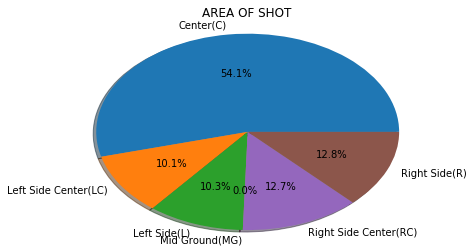

In [33]:
labels = is_goal['area_of_shot'].astype('category').cat.categories.tolist()
counts = is_goal['area_of_shot'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('normal')
ax1.set_title('AREA OF SHOT')
plt.show()

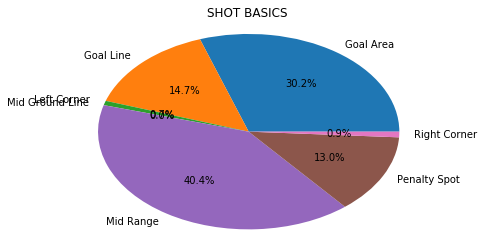

In [34]:
labels = is_goal['shot_basics'].astype('category').cat.categories.tolist()
counts = is_goal['shot_basics'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.set_title('SHOT BASICS')
ax1.axis('normal')
plt.show()

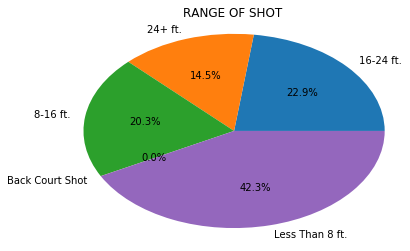

In [35]:
labels = is_goal['range_of_shot'].astype('category').cat.categories.tolist()
counts = is_goal['range_of_shot'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.set_title('RANGE OF SHOT')
ax1.axis('normal')
plt.show()

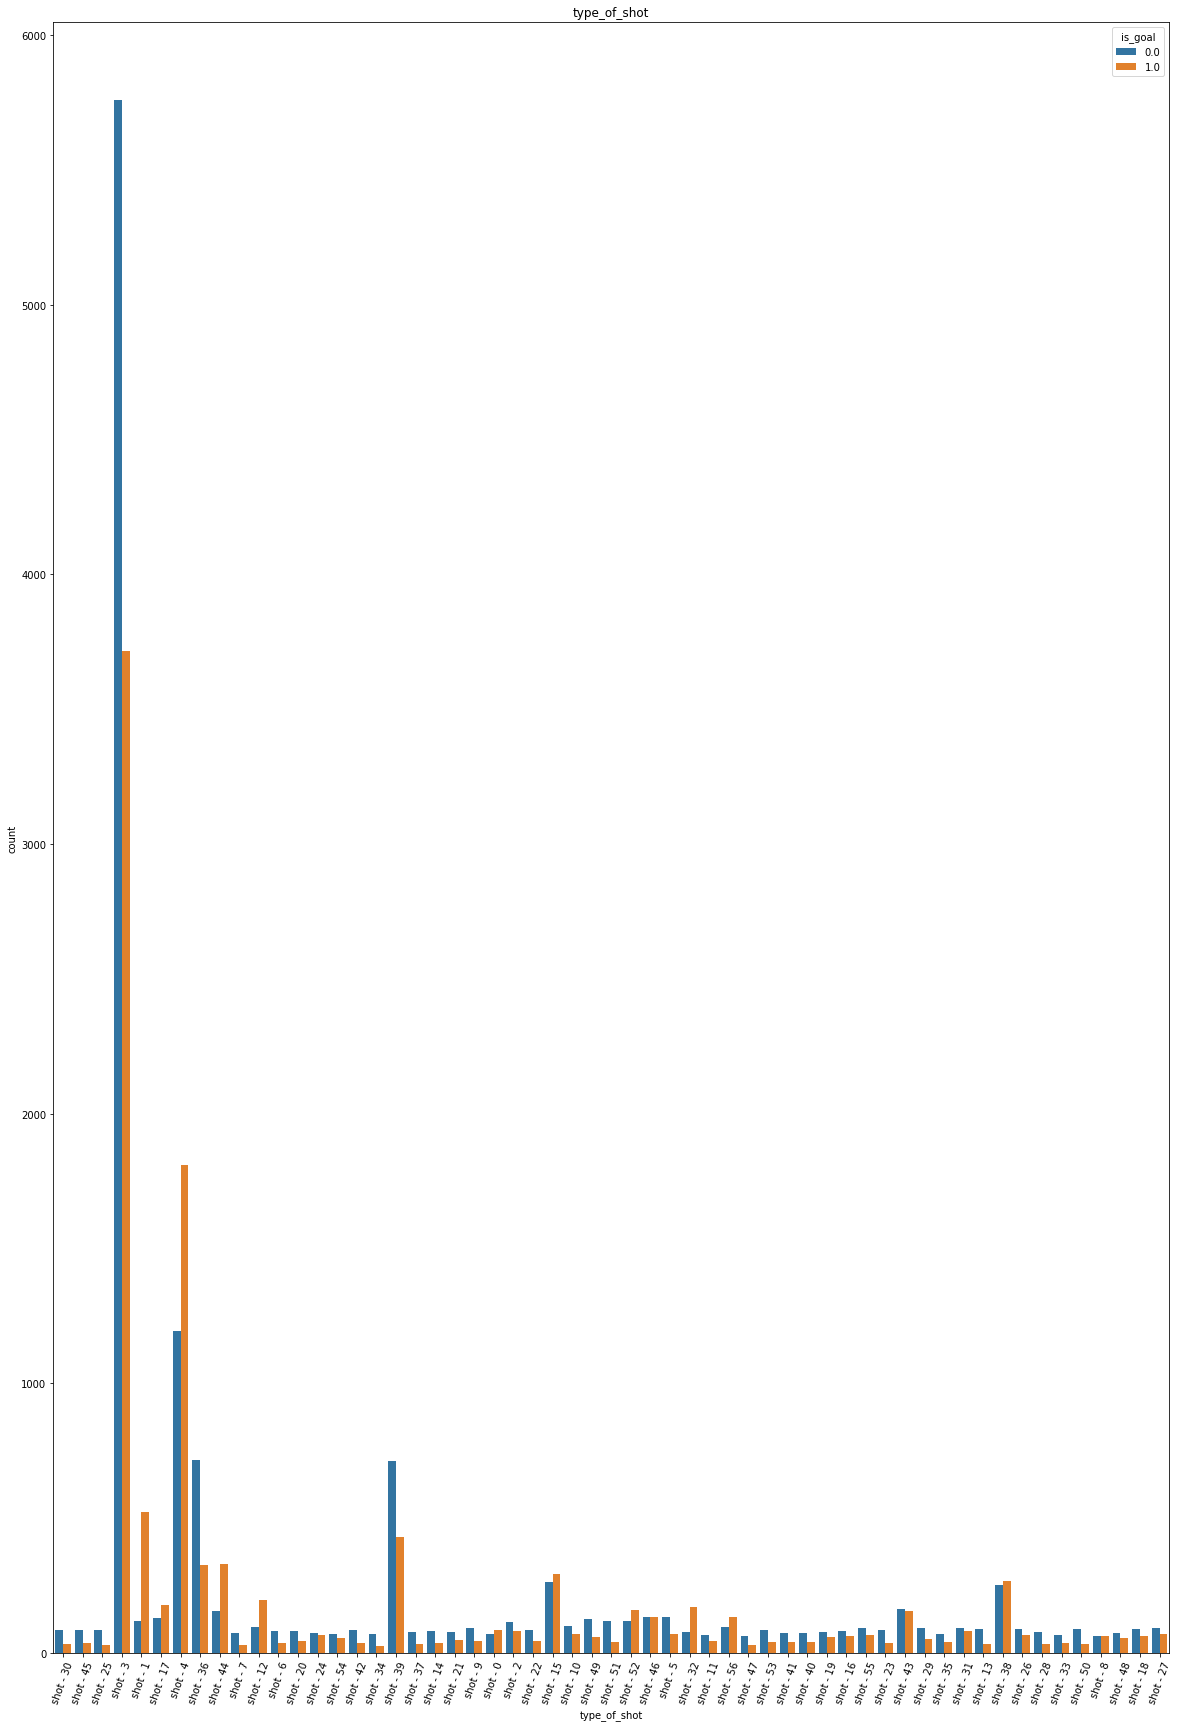

In [36]:
plt.figure(figsize=(20,30))
plt.title('type_of_shot')
plt.xticks(rotation=70)
sns.countplot(eda_data['type_of_shot'], hue=eda_data['is_goal'] )
plt.show()

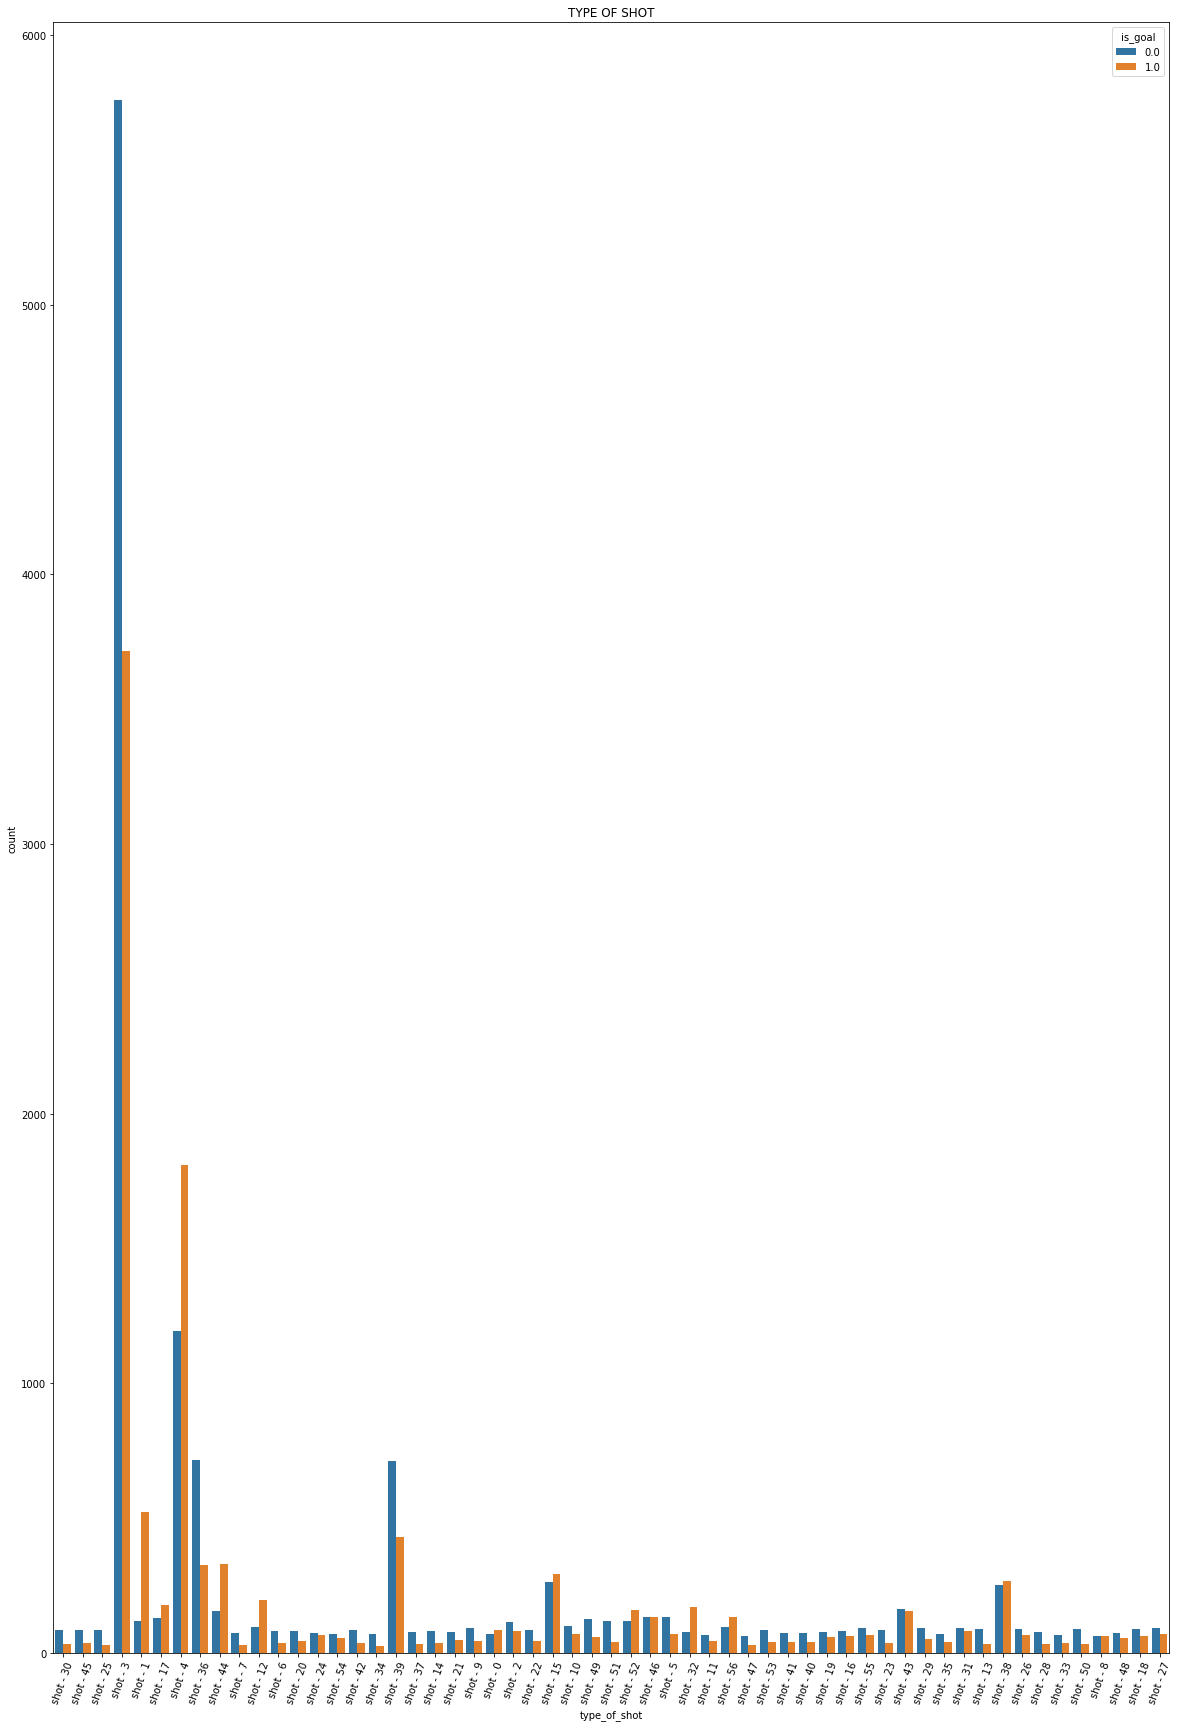

In [37]:
plt.figure(figsize=(20,30))
plt.title('TYPE OF SHOT')
plt.xticks(rotation=70)
sns.countplot(eda_data['type_of_shot'], hue=eda_data['is_goal'] )
plt.show()

In [38]:
pd.crosstab(index=eda_data['home/away'], columns=eda_data['is_goal'], margins=True, normalize='index')*100

is_goal,0.0,1.0
home/away,,
MANU vs. ATL,53.768844,46.231156
MANU vs. BKN,61.904762,38.095238
MANU vs. BOS,58.605974,41.394026
MANU vs. CHA,54.848485,45.151515
MANU vs. CHH,60.504202,39.495798
MANU vs. CHI,58.280922,41.719078
MANU vs. CLE,56.017505,43.982495
MANU vs. DAL,54.416576,45.583424
MANU vs. DEN,54.508197,45.491803


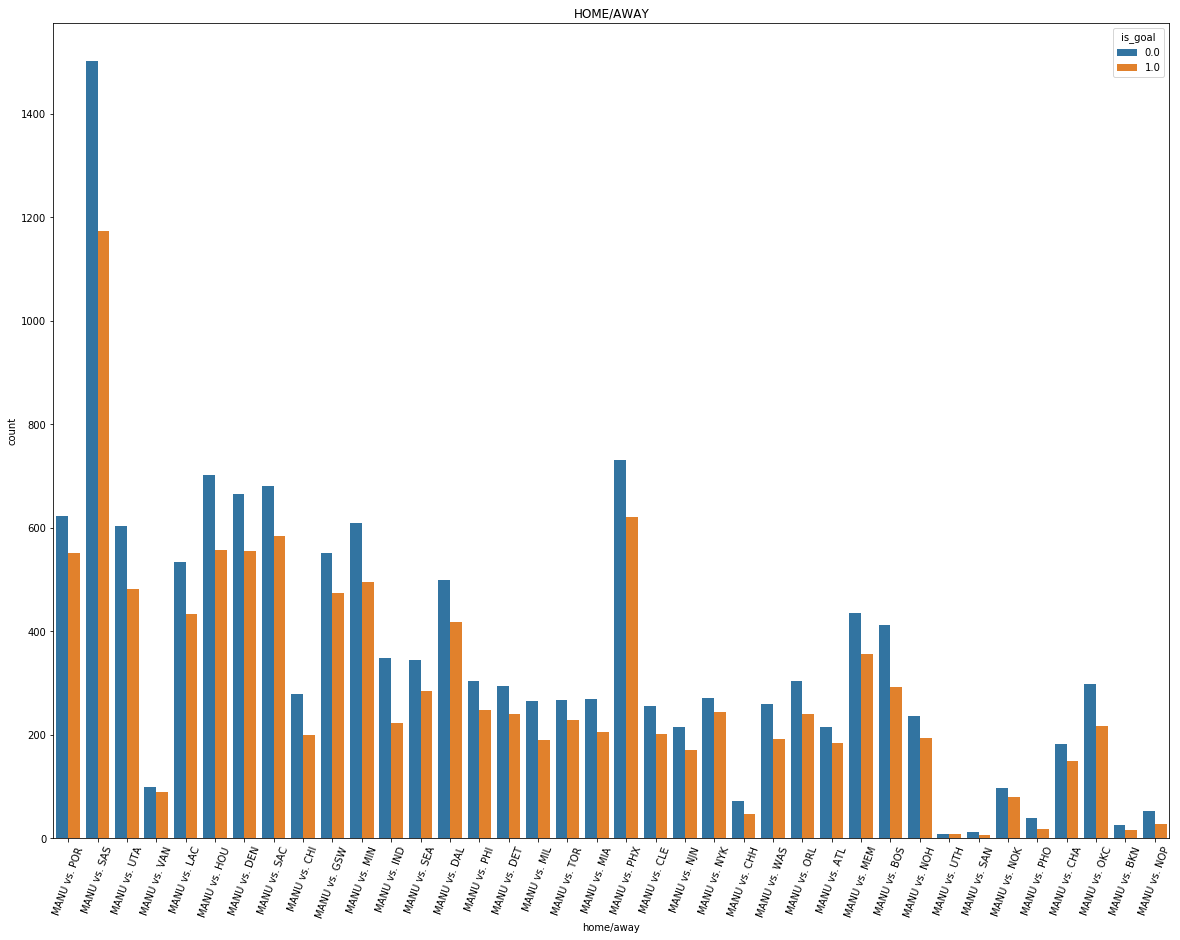

In [39]:
plt.figure(figsize=(20,15))
plt.title('HOME/AWAY')
plt.xticks(rotation=70)
sns.countplot(eda_data['home/away'], hue=eda_data['is_goal'])
plt.show()

Observation:
- Ronaldo has attempted & scored maximum number against 'SAS'.
- However, his % of success is highest against 'NYK' and 'VAN'
- His lowest % of success is against 'PHO'

## lat/lng

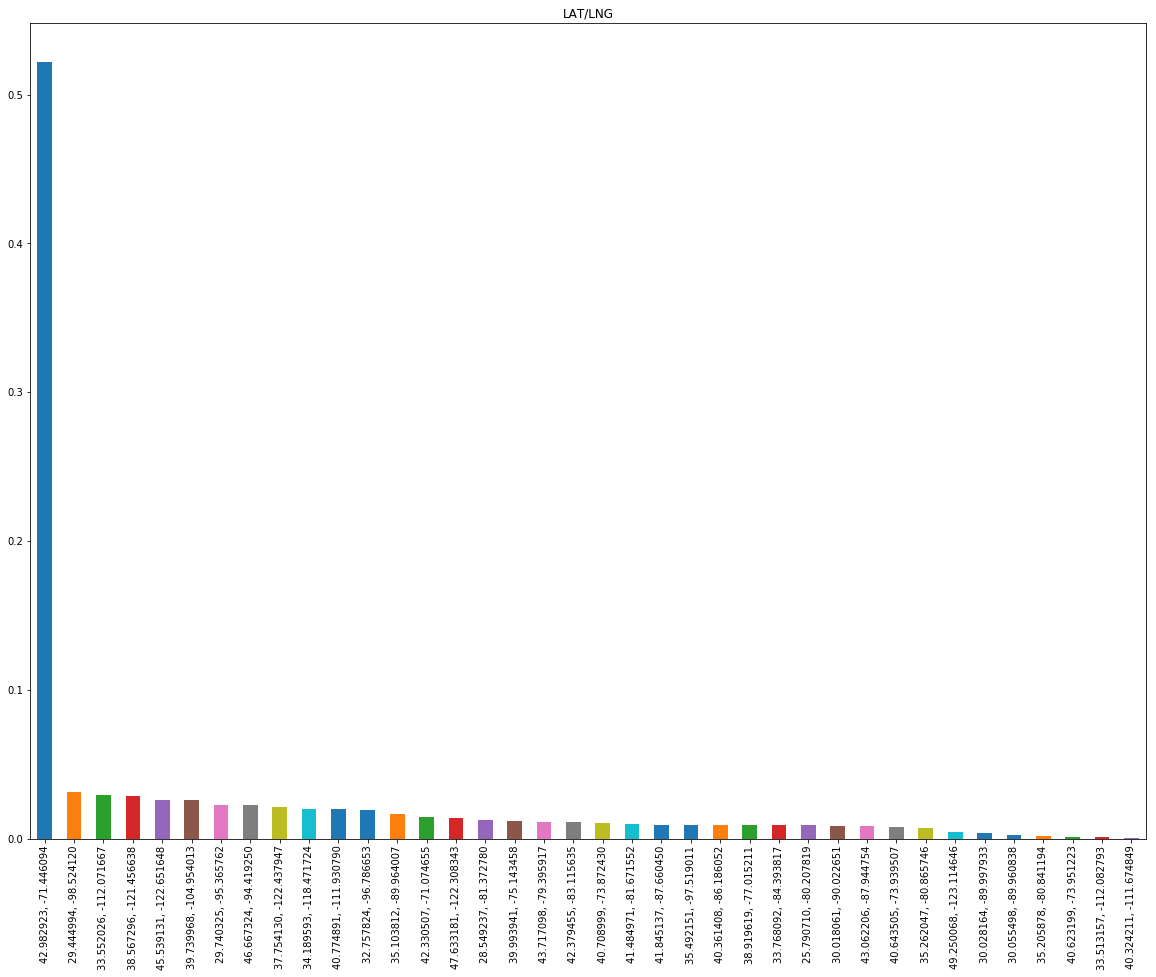

In [40]:
plt.figure(figsize=(20,15))
plt.title('LAT/LNG')
plt.xticks(rotation=70)
is_goal['lat/lng'].value_counts(normalize=True).plot.bar()
plt.show()

Observation:

- Out of all attempts, his maximum attempts(51%) are from '42.982923, -71.446094' lat/lng
- Out of all scores, his maximum scores(52%) are from '42.982923, -71.446094' lat/lng

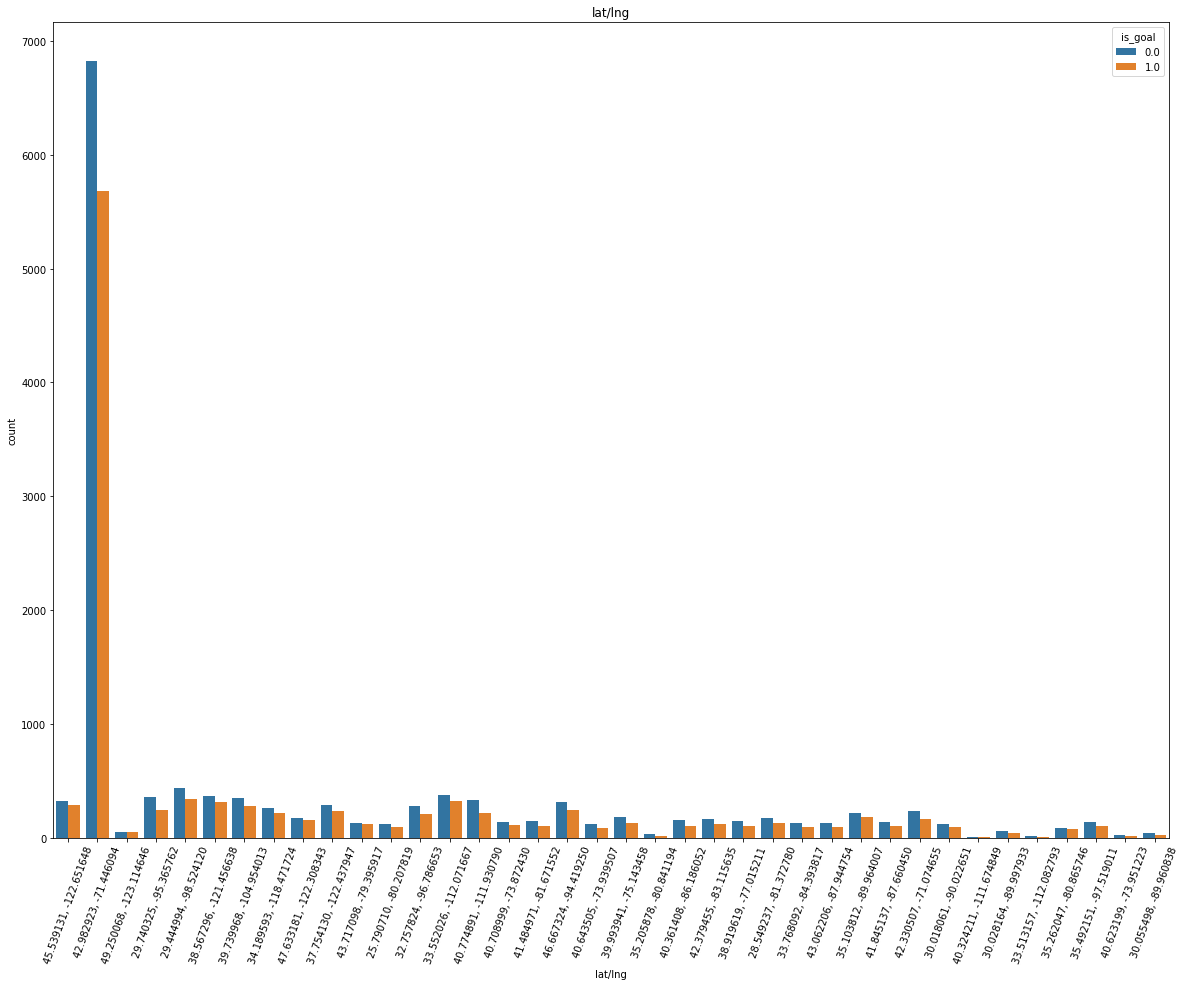

In [41]:
plt.figure(figsize=(20,15))
plt.title('lat/lng')
plt.xticks(rotation=70)
ax = sns.countplot(eda_data['lat/lng'], hue=eda_data['is_goal'])
plt.show()

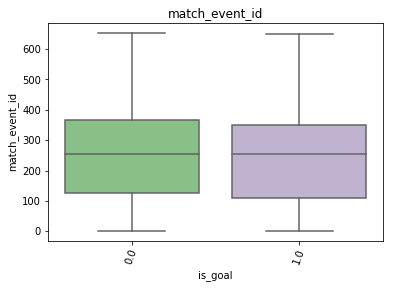

In [42]:
plt.title('match_event_id')
plt.xticks(rotation=70)
sns.boxplot('is_goal','match_event_id', data=eda_data, palette='Accent')
#ax = sns.boxplot(train['match_event_id'], hue=train['is_goal'])
plt.show()

In [43]:
eda_data.columns , df.columns

(Index(['is_goal', 'area_of_shot', 'shot_basics', 'range_of_shot', 'home/away',
        'lat/lng', 'type_of_shot', 'season_of_game', 'match_event_id',
        'location_x', 'location_y', 'power_of_shot', 'knockout_match',
        'distance_of_shot', 'match_id', 'remaining_min.1', 'power_of_shot.1',
        'knockout_match.1', 'remaining_sec.1', 'distance_of_shot.1',
        'remaining_seconds', 'remaining_seconds.1'],
       dtype='object'),
 Index(['is_goal', 'area_of_shot', 'shot_basics', 'range_of_shot', 'home/away',
        'lat/lng', 'type_of_shot', 'season_of_game', 'match_event_id',
        'location_x', 'location_y', 'power_of_shot', 'knockout_match',
        'distance_of_shot', 'match_id', 'remaining_min.1', 'power_of_shot.1',
        'knockout_match.1', 'remaining_sec.1', 'distance_of_shot.1',
        'remaining_seconds', 'remaining_seconds.1'],
       dtype='object'))

### season_of_game

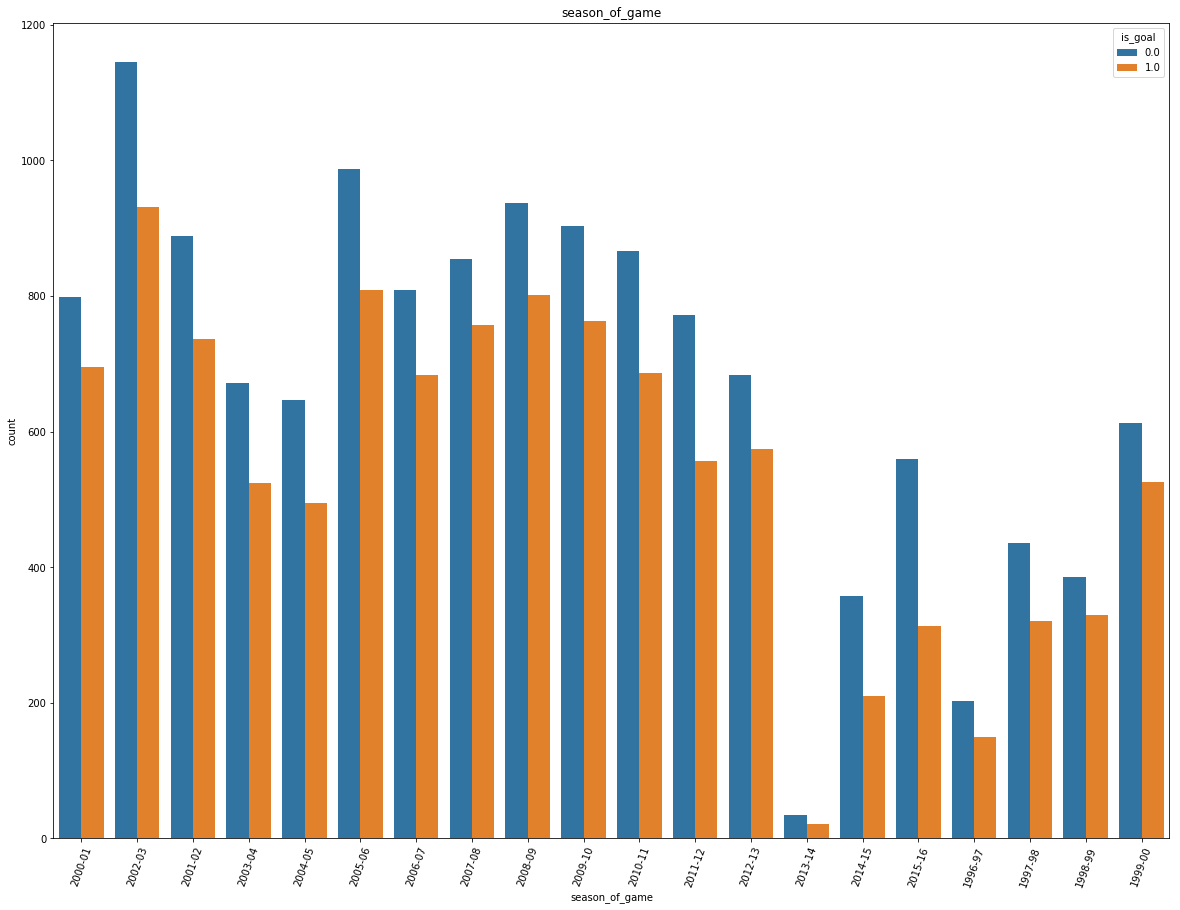

In [44]:
plt.figure(figsize=(20,15))
plt.title('season_of_game')
plt.xticks(rotation=70)
ax = sns.countplot(eda_data['season_of_game'], hue=eda_data['is_goal'])
plt.show()

In [45]:
pd.crosstab(index=eda_data['season_of_game'], columns=eda_data['is_goal'], margins=True, normalize='index')*100

is_goal,0.0,1.0
season_of_game,,
1996-97,57.670455,42.329545
1997-98,57.595773,42.404227
1998-99,53.846154,46.153846
1999-00,53.866432,46.133568
2000-01,53.480589,46.519411
2001-02,54.679803,45.320197
2002-03,55.149182,44.850818
2003-04,56.150628,43.849372
2004-05,56.666667,43.333333


In [46]:
eda_data['power_of_shot'].value_counts() , eda_data['power_of_shot.1'].value_counts()

(3.0    9371
 1.0    7659
 4.0    6910
 2.0    6399
 5.0     314
 6.0      37
 7.0       7
 Name: power_of_shot, dtype: int64, 3.00      7807
 1.00      6085
 4.00      5485
 2.00      5093
 5.00       263
 95.36       75
 83.36       71
 80.36       69
 30.36       68
 72.36       68
 74.36       67
 94.36       67
 112.36      66
 85.36       66
 81.36       65
 106.36      63
 29.36       63
 101.36      62
 24.36       62
 99.36       62
 103.36      62
 44.36       62
 26.36       62
 58.36       61
 78.36       61
 40.36       61
 41.36       61
 57.36       61
 52.36       60
 117.36      60
           ... 
 109.60       3
 78.60        3
 42.60        3
 64.60        3
 67.60        3
 89.60        3
 38.60        2
 62.60        2
 105.60       2
 49.60        2
 86.60        2
 36.60        2
 68.60        2
 84.60        2
 30.60        2
 19.60        2
 20.60        2
 37.60        2
 46.60        2
 34.60        2
 104.60       1
 57.60        1
 82.60        1
 50.60    

In [47]:
eda_data['knockout_match'].value_counts() , eda_data['knockout_match.1'].value_counts()

(0.0    26438
 1.0     4259
 Name: knockout_match, dtype: int64, 0.00000      21324
 1.00000       3382
 87.60800        38
 132.60800       33
 38.60800        31
 93.60800        30
 95.60800        30
 129.60800       30
 40.60800        30
 81.60800        29
 53.60800        29
 47.80000        29
 105.60800       28
 88.60800        28
 58.60800        28
 41.80000        28
 137.60800       27
 108.60800       27
 45.60800        27
 101.60800       27
 133.60800       27
 47.60800        27
 127.60800       27
 85.60800        27
 62.60800        27
 103.80000       27
 125.92800       27
 121.60800       27
 36.92800        27
 89.80000        26
              ...  
 83.35232         2
 106.35232        2
 100.35232        2
 111.35232        2
 127.35232        2
 114.35232        2
 58.35232         2
 72.35232         2
 89.35232         2
 88.35232         2
 81.35232         1
 113.35232        1
 139.35232        1
 105.35232        1
 110.35232        1
 75.35232       

In [48]:
eda_data['distance_of_shot'].value_counts() , eda_data['distance_of_shot.1'].value_counts()

(20.0    5258
 35.0    2670
 45.0    1856
 44.0    1433
 37.0    1415
 38.0    1341
 36.0    1339
 39.0    1299
 46.0    1213
 40.0    1144
 34.0    1011
 33.0     892
 41.0     768
 32.0     745
 27.0     672
 30.0     668
 31.0     652
 42.0     646
 28.0     640
 26.0     611
 21.0     597
 29.0     581
 22.0     541
 43.0     539
 25.0     508
 47.0     486
 23.0     361
 24.0     350
 48.0     181
 49.0      77
         ... 
 63.0       5
 72.0       4
 78.0       4
 64.0       4
 69.0       4
 76.0       4
 82.0       3
 79.0       3
 75.0       3
 70.0       3
 74.0       3
 71.0       3
 94.0       3
 67.0       3
 68.0       3
 73.0       2
 81.0       2
 66.0       2
 65.0       2
 88.0       2
 90.0       2
 87.0       2
 84.0       2
 97.0       1
 89.0       1
 80.0       1
 77.0       1
 85.0       1
 99.0       1
 91.0       1
 Name: distance_of_shot, Length: 73, dtype: int64, 20.000    4232
 36.000    2604
 45.000    1511
 44.000    1162
 37.000    1125
 38.000    1086


In [49]:
eda_data['remaining_seconds'].value_counts() , eda_data['remaining_seconds.1'].value_counts()

(0.0      468
 28.0     273
 328.0    256
 148.0    197
 1.0      196
 268.0    195
 208.0    173
 88.0     171
 388.0    171
 688.0    146
 508.0    143
 568.0    142
 448.0    133
 628.0    125
 2.0      120
 300.0     89
 3.0       88
 323.0     81
 4.0       80
 320.0     79
 311.0     78
 301.0     78
 305.0     78
 327.0     77
 342.0     76
 37.0      75
 302.0     73
 316.0     73
 359.0     72
 318.0     72
         ... 
 486.0     24
 490.0     24
 533.0     24
 588.0     24
 461.0     24
 506.0     23
 639.0     23
 403.0     23
 594.0     23
 564.0     22
 539.0     22
 13.0      22
 467.0     22
 484.0     22
 429.0     22
 586.0     22
 694.0     21
 363.0     21
 695.0     21
 602.0     21
 693.0     20
 690.0     20
 692.0     19
 709.0     15
 691.0     13
 710.0     11
 712.0      3
 714.0      2
 711.0      2
 713.0      2
 Name: remaining_seconds, Length: 715, dtype: int64, 0.0000       289
 35.0000      207
 395.0000     197
 215.0000     144
 95.0000      140
 1.0

In [50]:
#intuitively, it appears that all the .1 columns are redundant and have lots of #invalid data. 
#(reason: number of unique values and range - both are very high compared to main columns, 
#eg. knockout_match match can be yes/no (1,0). but it's .1 column has too many unique values) 
# Hence, removing those columns from the dataset to be used for model building

df = df.drop(['remaining_seconds.1', 'distance_of_shot.1', 'knockout_match.1','power_of_shot.1', 'remaining_min.1', 'remaining_sec.1' ], axis=1)

In [51]:
df.columns

Index(['is_goal', 'area_of_shot', 'shot_basics', 'range_of_shot', 'home/away',
       'lat/lng', 'type_of_shot', 'season_of_game', 'match_event_id',
       'location_x', 'location_y', 'power_of_shot', 'knockout_match',
       'distance_of_shot', 'match_id', 'remaining_seconds'],
      dtype='object')

# Model Building

In [52]:
def model_scores(model_name, MAE, score, MAE_val, score_val):
    result = pd.DataFrame(index = ['MAE - Training', 'score - Training', 'MAE - Validation', 'Score - Validation', ])
    result[model_name] = [MAE, 
                         score,
                         MAE_val, 
                         score_val]
    return result

In [53]:
rd_state = 0

In [54]:
df_dummies = pd.get_dummies(df, drop_first=True)
train_data = df_dummies[df_dummies['is_goal'].notna()]
test_data = df_dummies[df_dummies['is_goal'].isna()]

train_data.shape, test_data.shape

((24429, 173), (6268, 173))

In [55]:
Y = train_data['is_goal']
X = train_data.drop('is_goal', axis=1)

#### Important Features:

In [56]:
# Feature importance calculation using ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(n_estimators=100, random_state=rd_state)
model.fit(X, Y)
features = pd.DataFrame(index=X.columns, data=model.feature_importances_*100, columns=['importance'])

In [57]:
imp_features = features['importance'].sort_values(ascending=False).index[:20]
print(imp_features)
#X=X[imp_features]

Index(['remaining_seconds', 'match_event_id', 'location_y', 'match_id',
       'location_x', 'distance_of_shot', 'power_of_shot',
       'lat/lng_42.982923, -71.446094', 'type_of_shot_shot - 3',
       'range_of_shot_Less Than 8 ft.', 'home/away_MANU vs. SAS',
       'season_of_game_2002-03', 'knockout_match', 'type_of_shot_shot - 1',
       'season_of_game_2008-09', 'season_of_game_2005-06',
       'season_of_game_2007-08', 'season_of_game_2001-02',
       'season_of_game_2006-07', 'season_of_game_2000-01'],
      dtype='object')


In [58]:
#Split into train and validation dataset
x_trn, x_val, y_trn, y_val = train_test_split(X, Y, test_size=0.3, random_state=rd_state)

# Handle class-imbalance in the training dataset

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=rd_state)
x_trn_sm, y_trn_sm = sm.fit_sample(x_trn, y_trn)

#### Random Forest

In [59]:
# Random Forest
model_rm = RandomForestClassifier(bootstrap=True, 
                                  criterion='entropy',
                                  max_depth=None, 
                                  max_leaf_nodes=None,
                                  min_samples_leaf=8, 
                                  min_samples_split=6,
                                  n_estimators=100, 
                                  n_jobs=4,
                                  random_state=rd_state,)

model_rm.fit(x_trn_sm, y_trn_sm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [60]:
# training dataset prediction

y_trn_predict = model_rm.predict(x_trn)
MAE = mean_absolute_error(y_trn, y_trn_predict)
score = 1/(1+ MAE)

# Validation dataset prediction
y_val_predict = model_rm.predict(x_val)
MAE_val = mean_absolute_error(y_val, y_val_predict)
score_val = 1/(1+ MAE_val)

scores_rm = model_scores('Random Forest', MAE, score, MAE_val, score_val)
scores_rm


,Random Forest
MAE - Training,0.290000
score - Training,0.775194
MAE - Validation,0.374267
Score - Validation,0.727661


In [61]:
scores = cross_validate(model_rm, x_trn, y_trn, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)

In [62]:
scores

{'fit_time': array([11.2026937 ,  1.8316524 ,  1.78733087,  1.87316179,  1.75036001]),
 'score_time': array([0.12095332, 0.11093736, 0.11075187, 0.11292648, 0.11052036]),
 'test_score': array([-0.36772873, -0.35808243, -0.36578947, -0.36384908, -0.36267915]),
 'train_score': array([-0.31230353, -0.30828277, -0.31388889, -0.31079599, -0.31452379])}

#### Logistic Regression:

In [63]:
model_lr=LogisticRegression(random_state=rd_state, solver='newton-cg', 
                            max_iter=2000, penalty='none', )
model_lr.fit(x_trn_sm, y_trn_sm)



C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=0, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
# training dataset prediction

y_trn_predict = model_lr.predict(x_trn)
MAE = mean_absolute_error(y_trn, y_trn_predict)
score = 1/(1+ MAE)

# Validation dataset prediction
y_val_predict = model_lr.predict(x_val)
MAE_val = mean_absolute_error(y_val, y_val_predict)
score_val = 1/(1+ MAE_val)

scores_lr = model_scores('Logistic Regression', MAE, score, MAE_val, score_val)
scores_lr

,Logistic Regression
MAE - Training,0.376725
score - Training,0.726361
MAE - Validation,0.389685
Score - Validation,0.719588


In [65]:
scores = cross_validate(model_lr, x_trn_sm, y_trn_sm, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

In [66]:
scores

{'fit_time': array([ 6.43031096,  6.90504122, 43.71493459, 17.71283507, 20.70512867]),
 'score_time': array([0.00200295, 0.00199962, 0.00300074, 0.00199938, 0.00200009]),
 'test_score': array([-0.40073145, -0.40569488, -0.40308255, -0.40642969, -0.36487193]),
 'train_score': array([-0.38091194, -0.38541939, -0.37620852, -0.37955585, -0.38602221])}

#### Naive Bayes

In [67]:
# BernoulliNB
model_gnb = BernoulliNB(fit_prior=True)
model_gnb.fit(x_trn_sm, y_trn_sm)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [68]:
# training dataset prediction

y_trn_predict = model_gnb.predict(x_trn)
MAE = mean_absolute_error(y_trn, y_trn_predict)
score = 1/(1+ MAE)

# Validation dataset prediction
y_val_predict = model_gnb.predict(x_val)
MAE_val = mean_absolute_error(y_val, y_val_predict)
score_val = 1/(1+ MAE_val)

scores_nb = model_scores('BernoulliNB', MAE, score, MAE_val, score_val)
scores_nb

,BernoulliNB
MAE - Training,0.398772
score - Training,0.714913
MAE - Validation,0.404694
Score - Validation,0.711899


In [69]:
scores = cross_validate(model_gnb, x_trn, y_trn, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)

In [70]:
scores

{'fit_time': array([0.09694362, 0.0739572 , 0.06995964, 0.06795812, 0.0719564 ]),
 'score_time': array([0.02198815, 0.01499271, 0.01698995, 0.01699257, 0.01699114]),
 'test_score': array([-0.3908214 , -0.3981292 , -0.3871345 , -0.38871015, -0.40625914]),
 'train_score': array([-0.39162219, -0.39008699, -0.39005848, -0.39032234, -0.38783715])}

#### knn

In [71]:
model_knn = KNeighborsClassifier(n_jobs=4, n_neighbors=20,  algorithm='kd_tree', leaf_size=10, weights='distance')
model_knn.fit(x_trn_sm, y_trn_sm)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=4, n_neighbors=20, p=2,
                     weights='distance')

In [72]:
# training dataset prediction

y_trn_predict = model_knn.predict(x_trn)
MAE = mean_absolute_error(y_trn, y_trn_predict)
score = 1/(1+ MAE)

# Validation dataset prediction
y_val_predict = model_knn.predict(x_val)
MAE_val = mean_absolute_error(y_val, y_val_predict)
score_val = 1/(1+ MAE_val)

scores_knn = model_scores('KNN', MAE, score, MAE_val, score_val)
scores_knn

,KNN
MAE - Training,0.000000
score - Training,1.000000
MAE - Validation,0.468413
Score - Validation,0.681007


In [73]:
scores = cross_validate(model_knn, x_trn, y_trn, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)

In [74]:
scores

{'fit_time': array([0.25287414, 0.2138772 , 0.22786927, 0.25285339, 0.22087407]),
 'score_time': array([0.53968811, 0.46786857, 0.50033355, 0.40025663, 0.52626014]),
 'test_score': array([-0.44314528, -0.45629933, -0.45847953, -0.43901726, -0.45481135]),
 'train_score': array([-0., -0., -0., -0., -0.])}

#### Model selection & Test data result

In [75]:
final_result = pd.DataFrame()
final_result = pd.concat([scores_rm, scores_lr, scores_nb, scores_knn], axis=1, sort=False)
final_result.to_csv("model_selection.csv")

In [76]:
# So, clearly 'Random Forest' model is better than others. So, choosing it as final model.

In [77]:
Y1 = test_data['is_goal']
X1 = test_data.drop('is_goal', axis=1)
#X1 = X1[imp_features]
X1.shape, Y1.shape

((6268, 172), (6268,))

In [83]:
result = pd.DataFrame(index=Y1.index.values)
result['is_goal'] = model_rm.predict_proba(X1)[:,1:]
result.to_csv("result_2.csv")